In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

2023-12-06 19:28:20.369394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

### Dataset

In [32]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
dataset

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


### Dataset Information

In [33]:
print(list(dataset.columns))

['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A', 'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B', 'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26', 'TWS_S26', 'PUMP_S26', 'MEAN_RAIN']


In [34]:
data = dataset[['MEAN_RAIN', 'WS_S4',
                'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
                'PUMP_S25B', 'PUMP_S26',
                #'FLOW_S25A', 'FLOW_S25B', 'FLOW_S26', 
                'HWS_S25A', 'HWS_S25B', 'HWS_S26',
                'WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
data

,MEAN_RAIN,WS_S4,GATE_S25A,GATE_S25B,GATE_S25B2,GATE_S26_1,GATE_S26_2,PUMP_S25B,PUMP_S26,HWS_S25A,HWS_S25B,HWS_S26,WS_S1,TWS_S25A,TWS_S25B,TWS_S26
Time,,,,,,,,,,,,,,,,
1/1/10 00:00,0.0,0.34,0.0,0.0,0.0,0.0,0.00,0.0,0.0,2.17,2.84,2.78,0.33,0.49,0.58,0.505
1/1/10 01:00,0.0,-0.28,0.0,0.0,0.0,0.0,0.00,0.0,0.0,2.17,2.84,2.78,-0.29,0.02,-0.07,-0.110
1/1/10 02:00,0.0,-0.73,0.0,0.0,0.0,0.0,0.00,0.0,0.0,2.17,2.84,2.79,-0.81,-0.49,-0.62,-0.650
1/1/10 03:00,0.0,-0.85,0.0,0.0,0.0,0.0,0.00,0.0,0.0,2.15,2.83,2.79,-0.98,-0.75,-0.82,-0.850
1/1/10 04:00,0.0,-0.49,0.0,0.0,0.0,0.0,0.00,0.0,0.0,2.13,2.84,2.79,-0.69,-0.55,-0.53,-0.550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,0.0,1.19,0.0,0.0,0.0,0.0,2.61,0.0,0.0,1.92,2.86,2.49,1.24,1.25,1.31,1.290
12/31/20 20:00,0.0,1.61,0.0,0.0,0.0,0.0,2.62,0.0,0.0,1.92,2.88,2.48,1.62,1.64,1.68,1.660
12/31/20 21:00,0.0,1.90,0.0,0.0,0.0,0.0,2.62,0.0,0.0,1.93,2.89,2.54,1.98,2.00,2.04,2.040


In [35]:
x = dataset[['MEAN_RAIN', 'WS_S4',
            'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'GATE_S26_1', 'GATE_S26_2',
            'PUMP_S25B', 'PUMP_S26',
            'HWS_S25A', 'HWS_S25B', 'HWS_S26',
            ]]  # 'TWS_S25A', 'TWS_S25B', 'TWS_S26'
x.shape

(96432, 12)

In [36]:
y = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
y.shape

(96432, 4)

### Concatenation

### Train & Test set

In [37]:
x_np = x.values
y_np = y.values

n_train_hours = int(len(x_np)*0.8)
print("n_train_hours:", n_train_hours)


train_x = x_np[:n_train_hours, :]    # 0 column is the rainfall to measure heavy/medium/light
test_x = x_np[n_train_hours:, :]

train_y = y_np[:n_train_hours, :]
test_y = y_np[n_train_hours:, :]

n_train_hours: 77145


In [42]:
test_x.shape

(19287, 12)

### Model

In [62]:
model = keras.Sequential()

# Add a Dense layer for multivariate linear regression with two input units and two output units
model.add(layers.Input(shape=(12,)))  # Input layer for two features
model.add(layers.Dense(units=4))  # Output layer with two units (for two output variables)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 52        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000
151/151 - 1s - loss: 5582.2622 - mae: 14.8880 - val_loss: 8808.7051 - val_mae: 24.4411

Epoch 00001: val_mae improved from inf to 24.44111, saving model to saved_model/lr.h5
Epoch 2/2000
151/151 - 0s - loss: 5568.6372 - mae: 14.8631 - val_loss: 8790.2500 - val_mae: 24.4054

Epoch 00002: val_mae improved from 24.44111 to 24.40541, saving model to saved_model/lr.h5
Epoch 3/2000
151/151 - 0s - loss: 5556.8940 - mae: 14.8419 - val_loss: 8772.4648 - val_mae: 24.3710

Epoch 00003: val_mae improved from 24.40541 to 24.37100, saving model to saved_model/lr.h5
Epoch 4/2000
151/151 - 0s - loss: 5545.3999 - mae: 14.8211 - val_loss: 8754.9443 - val_mae: 24.3371

Epoch 00004: val_mae improved from 24.37100 to 24.33712, saving model to saved_model/lr.h5
Epoch 5/2000
151/151 - 0s - loss: 5534.0332 - mae: 14.8006 - val_loss: 8737.5879 - val_mae: 24.3036

Epoch 00005: val_mae improved from 24.33712 to 24.30355, saving model to saved_model/lr.h5
Epoch 6/2000
151/151 - 0s - loss: 5522.7480 -

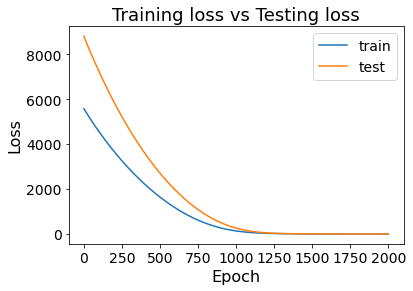

In [63]:
lr = 0.00001
EPOCHS = 2000
model.compile(
              optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=500)
mc = ModelCheckpoint('../saved_model/lr.h5', monitor='val_mae', mode='min', verbose=2, save_best_only=True)


history = model.fit(train_x, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_x, test_y),
                    verbose=2,
                    shuffle=False,
                               callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

### Prediction

In [64]:
from tensorflow.keras.models import load_model

model_load = load_model('../saved_model/lr.h5')

#### Test set

In [65]:
yhat = model_load.predict(test_x)
inv_yhat = yhat
inv_y = test_y

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19287, 4) (19287, 4)


### Performance

In [73]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

In [74]:
print('MAE = {}'.format(float("{:.6f}".format(mae(inv_y, inv_yhat)))))
print('RMSE = {}'.format(float("{:.6f}".format(sqrt(mse(inv_y, inv_yhat))))))

MAE = 0.169692
RMSE = 0.234629


In [ ]:
inv_yhat.to_csv('../output/inv_yhat_lr.csv')